# **Выбор датасета**

Мной был выбран датасет содержит данные здания, для энергетически эффективной работы отопления и охлаждения.

Классификация: предсказание класса по требованиям к отоплению.

Регрессия: предсказание требований к отоплению и охлаждению по заданным параметрам зданий.

Эта задача имеет практическое применение в строительстве. Определение класса отопления и определение самих требований отопления и охлаждения может помочь строителям, проектировщикам к более быстрым рассчетам.

# **Выбор метрик**

Для классификации я выбираю две метрики: accuracy, для общей оценки моделей, и f1, для оценки общей классификации.

Для регрессии я выбрал три метрики: MAE, для оценивания средней величины отклонений, MSE, для оценивания крупных ошибок, R2, для просмотра качества модели.

# Алгоритм KNN

## Задача Классификации

Импортируем нужные библиотеки

In [2]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

Загрузим данные датасета, для удобства поменяем названия колонок и выведем первые данные датасета для просмотра


In [3]:
data = pd.read_csv('energy_efficiency_data.csv')

data.columns = [
    "Relative_Compactness", "Surface_Area", "Wall_Area", "Roof_Area",
    "Overall_Height", "Orientation", "Glazing_Area", "Glazing_Area_Distribution",
    "Heating_Load", "Cooling_Load"
]

data.head()


,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


<Axes: >

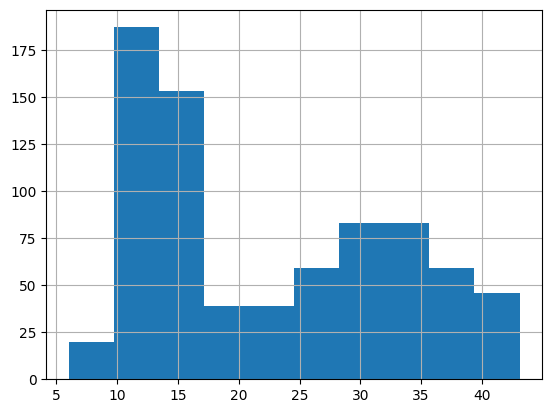

In [4]:
data.Heating_Load.hist()

Выберем переменную для классификации, и для удобства удалил ненужные столбцы

In [5]:
data['Heating_Load_Class'] = pd.qcut(data['Heating_Load'], q=3, labels=['Low', 'Medium', 'High'])

data = data.drop(['Heating_Load', 'Cooling_Load'], axis=1)


In [6]:
data.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load_Class
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,Medium
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,Medium
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,Medium
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,Medium
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,Medium


<Axes: >

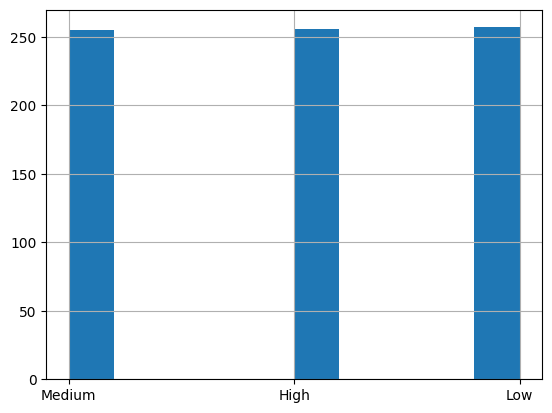

In [7]:
data.Heating_Load_Class.hist()

Разделим датасет на тестовую и обучающую выборки

In [8]:
X = data.drop('Heating_Load_Class', axis=1)
y = data['Heating_Load_Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}, Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (614, 8), Размер тестовой выборки: (154, 8)


Применим встроенный KNN для классификации

In [9]:
knn_baseline = KNeighborsClassifier()
knn_baseline.fit(X_train, y_train)

y_pred = knn_baseline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Бейзлайн:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

Бейзлайн:
Accuracy: 0.8831
F1-Score: 0.8826


Подберем гиперпараметры для улучшения безлайна

In [10]:
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

best_knn = grid_search.best_estimator_


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


Проведем обучение улучшенной модели и посчитаем метрики

In [11]:
y_pred_best = best_knn.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print("Улучшенный бейзлайн:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"F1-Score: {f1_best:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


Улучшенный бейзлайн:
Accuracy: 0.9091
F1-Score: 0.9065

Classification Report:
              precision    recall  f1-score   support

        High       0.93      0.98      0.95        51
         Low       0.86      0.98      0.92        52
      Medium       0.95      0.76      0.85        51

    accuracy                           0.91       154
   macro avg       0.91      0.91      0.91       154
weighted avg       0.91      0.91      0.91       154



Реализуем собственную имплементацию алгоритма

In [12]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class CustomKNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = np.array(y)

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

custom_knn = CustomKNN(k=best_params['n_neighbors'])
custom_knn.fit(X_train, y_train)

y_pred_custom = custom_knn.predict(X_test)

accuracy_custom = accuracy_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom, average='weighted')

print("Реализация Custom KNN:")
print(f"Accuracy: {accuracy_custom:.4f}")
print(f"F1-Score: {f1_custom:.4f}")


Реализация Custom KNN:
Accuracy: 0.8831
F1-Score: 0.8826


Сравним полученные резльтаты:

In [13]:
print("Сравнение результатов:")
print(f"Бейзлайн Accuracy: {accuracy:.4f}, Улучшенный Accuracy: {accuracy_best:.4f}, Custom KNN Accuracy: {accuracy_custom:.4f}")
print(f"Бейзлайн F1-Score: {f1:.4f}, Улучшенный F1-Score: {f1_best:.4f}, Custom KNN F1-Score: {f1_custom:.4f}")


Сравнение результатов:
Бейзлайн Accuracy: 0.8831, Улучшенный Accuracy: 0.9091, Custom KNN Accuracy: 0.8831
Бейзлайн F1-Score: 0.8826, Улучшенный F1-Score: 0.9065, Custom KNN F1-Score: 0.8826


## Задача регрессии

Импортируем нужные библиотеки

In [14]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Загрузим данные датасета, для удобства поменяем названия колонок, разделим данные на тестовую и обучающую выборку

In [15]:
data = pd.read_csv("energy_efficiency_data.csv")

X = data[
    [
        "Relative_Compactness",
        "Surface_Area",
        "Wall_Area",
        "Roof_Area",
        "Overall_Height",
        "Orientation",
        "Glazing_Area",
        "Glazing_Area_Distribution",
    ]
]
y_heating = data["Heating_Load"]
y_cooling = data["Cooling_Load"]

X_train, X_test, y_train_heating, y_test_heating = train_test_split(
    X, y_heating, test_size=0.2, random_state=42
)
X_train, X_test, y_train_cooling, y_test_cooling = train_test_split(
    X, y_cooling, test_size=0.2, random_state=42
)


<Axes: >

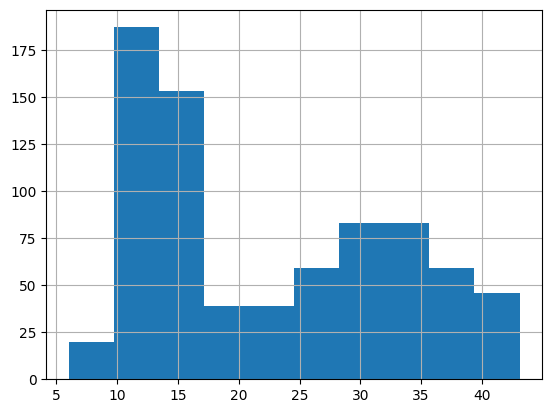

In [16]:
data.Heating_Load.hist()

<Axes: >

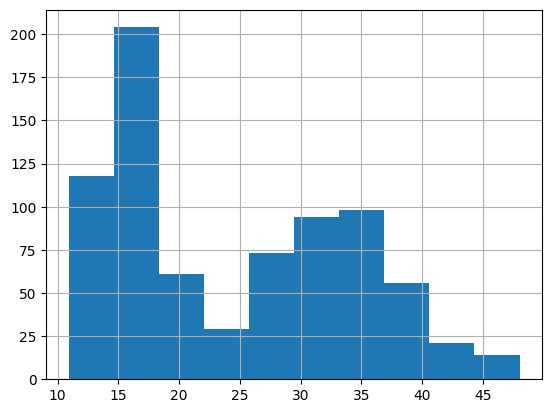

In [17]:
data.Cooling_Load.hist()

Обучение безлайна и оценка модели

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn_heating = KNeighborsRegressor(n_neighbors=5)
knn_heating.fit(X_train, y_train_heating)
y_pred_heating = knn_heating.predict(X_test)

knn_cooling = KNeighborsRegressor(n_neighbors=5)
knn_cooling.fit(X_train, y_train_cooling)
y_pred_cooling = knn_cooling.predict(X_test)

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2

print("Heating Load Metrics:")
mae_heating, mse_heating, r2_heating = evaluate_model(y_test_heating, y_pred_heating)
print(f"MAE: {mae_heating:.4f}, MSE: {mse_heating:.4f}, R²: {r2_heating:.4f}")

print("\nCooling Load Metrics:")
mae_cooling, mse_cooling, r2_cooling = evaluate_model(y_test_cooling, y_pred_cooling)
print(f"MAE: {mae_cooling:.4f}, MSE: {mse_cooling:.4f}, R²: {r2_cooling:.4f}")

Heating Load Metrics:
MAE: 1.4527, MSE: 5.2978, R²: 0.9492

Cooling Load Metrics:
MAE: 1.6537, MSE: 6.6717, R²: 0.9280


Подберем гиперпараметры для улучшения модели

In [19]:
param_grid = {"n_neighbors": range(1, 20)}

grid_heating = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring="r2",
    verbose=1,
)
grid_heating.fit(X_train, y_train_heating)

grid_cooling = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=5,
    scoring="r2",
    verbose=1,
)
grid_cooling.fit(X_train, y_train_cooling)

best_k_heating = grid_heating.best_params_["n_neighbors"]
best_k_cooling = grid_cooling.best_params_["n_neighbors"]

print(f"Лучший k для Heating_Load: {best_k_heating}")
print(f"Лучший k для Cooling_Load: {best_k_cooling}")


Fitting 5 folds for each of 19 candidates, totalling 95 fits
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Лучший k для Heating_Load: 2
Лучший k для Cooling_Load: 8


Обучим модели с подобранными гиперпараметрами

In [20]:
knn_heating_optimized = KNeighborsRegressor(n_neighbors=best_k_heating)
knn_heating_optimized.fit(X_train, y_train_heating)
y_pred_heating_optimized = knn_heating_optimized.predict(X_test)

knn_cooling_optimized = KNeighborsRegressor(n_neighbors=best_k_cooling)
knn_cooling_optimized.fit(X_train, y_train_cooling)
y_pred_cooling_optimized = knn_cooling_optimized.predict(X_test)

print("Optimized Heating Load Metrics:")
mae_heating_opt, mse_heating_opt, r2_heating_opt = evaluate_model(
    y_test_heating, y_pred_heating_optimized
)
print(f"MAE: {mae_heating_opt:.4f}, MSE: {mse_heating_opt:.4f}, R²: {r2_heating_opt:.4f}")

print("\nOptimized Cooling Load Metrics:")
mae_cooling_opt, mse_cooling_opt, r2_cooling_opt = evaluate_model(
    y_test_cooling, y_pred_cooling_optimized
)
print(f"MAE: {mae_cooling_opt:.4f}, MSE: {mse_cooling_opt:.4f}, R²: {r2_cooling_opt:.4f}")


Optimized Heating Load Metrics:
MAE: 1.0147, MSE: 3.4847, R²: 0.9666

Optimized Cooling Load Metrics:
MAE: 1.7068, MSE: 6.4198, R²: 0.9307


Реализуем собственную имплементацию алгоритма

In [21]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class CustomKNNRegressor:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = np.array(y)

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return np.mean(k_nearest_labels)

custom_knn_heating = CustomKNNRegressor(k=best_k_heating)
custom_knn_heating.fit(X_train, y_train_heating)
y_pred_custom_heating = custom_knn_heating.predict(X_test)

custom_knn_cooling = CustomKNNRegressor(k=best_k_cooling)
custom_knn_cooling.fit(X_train, y_train_cooling)
y_pred_custom_cooling = custom_knn_cooling.predict(X_test)


mae_custom_heating, mse_custom_heating, r2_custom_heating = evaluate_model(
    y_test_heating, y_pred_custom_heating
)

mae_custom_cooling, mse_custom_cooling, r2_custom_cooling = evaluate_model(
    y_test_cooling, y_pred_custom_cooling
)

print("Custom KNN Heating Load Metrics:")
print(f"MAE: {mae_custom_heating:.4f}, MSE: {mse_custom_heating:.4f}, R²: {r2_custom_heating:.4f}")

print("\nCustom KNN Cooling Load Metrics:")
print(f"MAE: {mae_custom_cooling:.4f}, MSE: {mse_custom_cooling:.4f}, R²: {r2_custom_cooling:.4f}")


Custom KNN Heating Load Metrics:
MAE: 1.0162, MSE: 3.4870, R²: 0.9665

Custom KNN Cooling Load Metrics:
MAE: 1.7187, MSE: 6.5426, R²: 0.9294


Сравнение всех полученных результатов

In [22]:
print("\nСравнение результатов для Heating Load:")
print(f"Бейзлайн MAE: {mae_heating:.4f}, Улучшенный MAE: {mae_heating_opt:.4f}, Custom KNN MAE: {mae_custom_heating:.4f}")
print(f"Бейзлайн MSE: {mse_heating:.4f}, Улучшенный MSE: {mse_heating_opt:.4f}, Custom KNN MSE: {mse_custom_heating:.4f}")
print(f"Бейзлайн R²: {r2_heating:.4f}, Улучшенный R²: {r2_heating_opt:.4f}, Custom KNN R²: {r2_custom_heating:.4f}")

print("\nСравнение результатов для Cooling Load:")
print(f"Бейзлайн MAE: {mae_cooling:.4f}, Улучшенный MAE: {mae_cooling_opt:.4f}, Custom KNN MAE: {mae_custom_cooling:.4f}")
print(f"Бейзлайн MSE: {mse_cooling:.4f}, Улучшенный MSE: {mse_cooling_opt:.4f}, Custom KNN MSE: {mse_custom_cooling:.4f}")
print(f"Бейзлайн R²: {r2_cooling:.4f}, Улучшенный R²: {r2_cooling_opt:.4f}, Custom KNN R²: {r2_custom_cooling:.4f}")



Сравнение результатов для Heating Load:
Бейзлайн MAE: 1.4527, Улучшенный MAE: 1.0147, Custom KNN MAE: 1.0162
Бейзлайн MSE: 5.2978, Улучшенный MSE: 3.4847, Custom KNN MSE: 3.4870
Бейзлайн R²: 0.9492, Улучшенный R²: 0.9666, Custom KNN R²: 0.9665

Сравнение результатов для Cooling Load:
Бейзлайн MAE: 1.6537, Улучшенный MAE: 1.7068, Custom KNN MAE: 1.7187
Бейзлайн MSE: 6.6717, Улучшенный MSE: 6.4198, Custom KNN MSE: 6.5426
Бейзлайн R²: 0.9280, Улучшенный R²: 0.9307, Custom KNN R²: 0.9294


# Алгоритм Линейных моделей

## Задача классификации

Импортируем нужные библиотеки

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.special import expit

Загрузим данные датасета, для удобства поменяем названия колонок и выведем первые данные датасета для просмотра

In [24]:
data = pd.read_csv('energy_efficiency_data.csv')

data.columns = [
    "Relative_Compactness", "Surface_Area", "Wall_Area", "Roof_Area",
    "Overall_Height", "Orientation", "Glazing_Area", "Glazing_Area_Distribution",
    "Heating_Load", "Cooling_Load"
]

data.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


Выберем переменную для классификации, и для удобства удалил ненужные столбцы

In [25]:
data['Heating_Load_Class'] = pd.qcut(data['Heating_Load'], q=3, labels=['Low', 'Medium', 'High'])

data = data.drop(['Heating_Load', 'Cooling_Load'], axis=1)


X = data.drop('Heating_Load_Class', axis=1)
y = data['Heating_Load_Class']


Разделим датасет на тестовую и обучающую выборки

In [26]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print(f"Размер обучающей выборки: {X_train.shape}, Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (614, 8), Размер тестовой выборки: (154, 8)


Применим встроенный алгоритм

In [27]:
lr_baseline = LogisticRegression(max_iter=1000, random_state=42)
lr_baseline.fit(X_train, y_train)

y_pred = lr_baseline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Бейзлайн:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Бейзлайн:
Accuracy: 0.8312
F1-Score: 0.8264

Classification Report:
              precision    recall  f1-score   support

        High       0.79      0.90      0.84        51
         Low       0.89      0.94      0.92        52
      Medium       0.80      0.65      0.72        51

    accuracy                           0.83       154
   macro avg       0.83      0.83      0.83       154
weighted avg       0.83      0.83      0.83       154



Подберем гиперпараметры для оптимизации безлайна

In [28]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'sag'],
    'penalty': ['l2']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Лучшие параметры: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


Обучение с подобранными гиперпараметрами

In [29]:
best_lr = grid_search.best_estimator_

y_pred_best = best_lr.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print("Улучшенный бейзлайн:")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"F1-Score: {f1_best:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

Улучшенный бейзлайн:
Accuracy: 0.8377
F1-Score: 0.8324

Classification Report:
              precision    recall  f1-score   support

        High       0.80      0.92      0.85        51
         Low       0.89      0.94      0.92        52
      Medium       0.82      0.65      0.73        51

    accuracy                           0.84       154
   macro avg       0.84      0.84      0.83       154
weighted avg       0.84      0.84      0.83       154



Имплементация алгоритма

In [30]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        y_encoded = self._one_hot_encode(y)
        self.weights = np.zeros((X.shape[1], len(self.classes_)))
        self.bias = np.zeros(len(self.classes_))

        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            probabilities = self._softmax(linear_model)
            dw = np.dot(X.T, (probabilities - y_encoded)) / X.shape[0]
            db = np.sum(probabilities - y_encoded, axis=0) / X.shape[0]

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        probabilities = self._softmax(linear_model)
        predictions = np.argmax(probabilities, axis=1)
        return self.classes_[predictions]

    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _one_hot_encode(self, y):
        y_encoded = np.zeros((y.shape[0], len(self.classes_)))
        for idx, class_ in enumerate(self.classes_):
            y_encoded[:, idx] = (y == class_).astype(float)
        return y_encoded

custom_lr = CustomLogisticRegression(learning_rate=0.1, n_iterations=1000)
custom_lr.fit(X_train, y_train)

y_pred_custom = custom_lr.predict(X_test)

accuracy_custom = accuracy_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom, average='weighted')

print("Имплементация:")
print(f"Accuracy: {accuracy_custom:.4f}")
print(f"F1-Score: {f1_custom:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_custom))

Имплементация:
Accuracy: 0.8377
F1-Score: 0.8324

Classification Report:
              precision    recall  f1-score   support

        High       0.79      0.90      0.84        51
         Low       0.89      0.96      0.93        52
      Medium       0.82      0.65      0.73        51

    accuracy                           0.84       154
   macro avg       0.84      0.84      0.83       154
weighted avg       0.84      0.84      0.83       154



Сравнение полученных результатов

In [31]:
print("Сравнение результатов:")
print(f"Бейзлайн Accuracy: {accuracy:.4f}, Улучшенный Accuracy: {accuracy_best:.4f}, Custom Accuracy: {accuracy_custom:.4f}")
print(f"Бейзлайн F1-Score: {f1:.4f}, Улучшенный F1-Score: {f1_best:.4f}, Custom F1-Score: {f1_custom:.4f}")

Сравнение результатов:
Бейзлайн Accuracy: 0.8312, Улучшенный Accuracy: 0.8377, Custom Accuracy: 0.8377
Бейзлайн F1-Score: 0.8264, Улучшенный F1-Score: 0.8324, Custom F1-Score: 0.8324


## Задача регрессии

Импортируем нужные библиотеки

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Загрузим данные датасета, для удобства поменяем названия колонок, разделим данные на тестовую и обучающую выборку

In [33]:
data = pd.read_csv("energy_efficiency_data.csv")

X = data[
    [
        "Relative_Compactness",
        "Surface_Area",
        "Wall_Area",
        "Roof_Area",
        "Overall_Height",
        "Orientation",
        "Glazing_Area",
        "Glazing_Area_Distribution",
    ]
]
y_heating = data["Heating_Load"]
y_cooling = data["Cooling_Load"]

X_train, X_test, y_train_heating, y_test_heating = train_test_split(
    X, y_heating, test_size=0.2, random_state=42
)
X_train, X_test, y_train_cooling, y_test_cooling = train_test_split(
    X, y_cooling, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучение безлайна и оценка модели

In [34]:
lr_heating = LinearRegression()
lr_heating.fit(X_train, y_train_heating)
y_pred_heating = lr_heating.predict(X_test)

lr_cooling = LinearRegression()
lr_cooling.fit(X_train, y_train_cooling)
y_pred_cooling = lr_cooling.predict(X_test)

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2

print("Heating Load Metrics (Linear Regression):")
mae_heating, mse_heating, r2_heating = evaluate_model(y_test_heating, y_pred_heating)
print(f"MAE: {mae_heating:.4f}, MSE: {mse_heating:.4f}, R²: {r2_heating:.4f}")

print("\nCooling Load Metrics (Linear Regression):")
mae_cooling, mse_cooling, r2_cooling = evaluate_model(y_test_cooling, y_pred_cooling)
print(f"MAE: {mae_cooling:.4f}, MSE: {mse_cooling:.4f}, R²: {r2_cooling:.4f}")

Heating Load Metrics (Linear Regression):
MAE: 2.1820, MSE: 9.1532, R²: 0.9122

Cooling Load Metrics (Linear Regression):
MAE: 2.1953, MSE: 9.8934, R²: 0.8932


Подбор гиперпараметров для оптимизации безлайна

In [35]:
param_grid = {"alpha": [0.01, 0.1, 1, 10, 100]}

grid_ridge_heating = GridSearchCV(Ridge(), param_grid, cv=5, scoring="r2", verbose=1)
grid_ridge_heating.fit(X_train, y_train_heating)

grid_ridge_cooling = GridSearchCV(Ridge(), param_grid, cv=5, scoring="r2", verbose=1)
grid_ridge_cooling.fit(X_train, y_train_cooling)

best_alpha_heating = grid_ridge_heating.best_params_["alpha"]
best_alpha_cooling = grid_ridge_cooling.best_params_["alpha"]


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


Обучение с подобранными гиперпараметрами

In [36]:
ridge_heating = Ridge(alpha=best_alpha_heating)
ridge_heating.fit(X_train, y_train_heating)
y_pred_ridge_heating = ridge_heating.predict(X_test)

ridge_cooling = Ridge(alpha=best_alpha_cooling)
ridge_cooling.fit(X_train, y_train_cooling)
y_pred_ridge_cooling = ridge_cooling.predict(X_test)

print("Optimized Heating Load Metrics (Ridge Regression):")
mae_ridge_heating, mse_ridge_heating, r2_ridge_heating = evaluate_model(
    y_test_heating, y_pred_ridge_heating
)
print(f"MAE: {mae_ridge_heating:.4f}, MSE: {mse_ridge_heating:.4f}, R²: {r2_ridge_heating:.4f}")

print("\nOptimized Cooling Load Metrics (Ridge Regression):")
mae_ridge_cooling, mse_ridge_cooling, r2_ridge_cooling = evaluate_model(
    y_test_cooling, y_pred_ridge_cooling
)
print(f"MAE: {mae_ridge_cooling:.4f}, MSE: {mse_ridge_cooling:.4f}, R²: {r2_ridge_cooling:.4f}")

Optimized Heating Load Metrics (Ridge Regression):
MAE: 2.1829, MSE: 9.1589, R²: 0.9121

Optimized Cooling Load Metrics (Ridge Regression):
MAE: 2.1949, MSE: 9.8955, R²: 0.8932


Имплементация алгоритма

In [37]:
class CustomLinearRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations

    def fit(self, X, y):
        self.m = X.shape[0]
        self.n = X.shape[1]
        self.weights = np.zeros(self.n)
        self.bias = 0

        for _ in range(self.n_iterations):
            y_predicted = self._predict(X)
            dw = -(2 / self.m) * np.dot(X.T, (y - y_predicted))
            db = -(2 / self.m) * np.sum(y - y_predicted)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        return self._predict(X)

    def _predict(self, X):
        return np.dot(X, self.weights) + self.bias

custom_lr_heating = CustomLinearRegression(learning_rate=0.01, n_iterations=1000)
custom_lr_heating.fit(X_train, y_train_heating)
y_pred_custom_heating = custom_lr_heating.predict(X_test)

custom_lr_cooling = CustomLinearRegression(learning_rate=0.01, n_iterations=1000)
custom_lr_cooling.fit(X_train, y_train_cooling)
y_pred_custom_cooling = custom_lr_cooling.predict(X_test)

mae_custom_heating, mse_custom_heating, r2_custom_heating = evaluate_model(
    y_test_heating, y_pred_custom_heating
)

mae_custom_cooling, mse_custom_cooling, r2_custom_cooling = evaluate_model(
    y_test_cooling, y_pred_custom_cooling
)

print("Custom Linear Regression Heating Load Metrics:")
print(f"MAE: {mae_custom_heating:.4f}, MSE: {mse_custom_heating:.4f}, R²: {r2_custom_heating:.4f}")

print("\nCustom Linear Regression Cooling Load Metrics:")
print(f"MAE: {mae_custom_cooling:.4f}, MSE: {mse_custom_cooling:.4f}, R²: {r2_custom_cooling:.4f}")

Custom Linear Regression Heating Load Metrics:
MAE: 2.2681, MSE: 10.0662, R²: 0.9034

Custom Linear Regression Cooling Load Metrics:
MAE: 2.3440, MSE: 11.0493, R²: 0.8808


Сравнение всех полученных результатов

In [38]:
print("\nСравнение результатов для Heating Load:")
print(f"Бейзлайн MAE: {mae_heating:.4f}, Улучшенный MAE: {mae_ridge_heating:.4f}, Custom MAE: {mae_custom_heating:.4f}")
print(f"Бейзлайн MSE: {mse_heating:.4f}, Улучшенный MSE: {mse_ridge_heating:.4f}, Custom MSE: {mse_custom_heating:.4f}")
print(f"Бейзлайн R²: {r2_heating:.4f}, Улучшенный R²: {r2_ridge_heating:.4f}, Custom R²: {r2_custom_heating:.4f}")

print("\nСравнение результатов для Cooling Load:")
print(f"Бейзлайн MAE: {mae_cooling:.4f}, Улучшенный MAE: {mae_ridge_cooling:.4f}, Custom MAE: {mae_custom_cooling:.4f}")
print(f"Бейзлайн MSE: {mse_cooling:.4f}, Улучшенный MSE: {mse_ridge_cooling:.4f}, Custom MSE: {mse_custom_cooling:.4f}")
print(f"Бейзлайн R²: {r2_cooling:.4f}, Улучшенный R²: {r2_ridge_cooling:.4f}, Custom R²: {r2_custom_cooling:.4f}")


Сравнение результатов для Heating Load:
Бейзлайн MAE: 2.1820, Улучшенный MAE: 2.1829, Custom MAE: 2.2681
Бейзлайн MSE: 9.1532, Улучшенный MSE: 9.1589, Custom MSE: 10.0662
Бейзлайн R²: 0.9122, Улучшенный R²: 0.9121, Custom R²: 0.9034

Сравнение результатов для Cooling Load:
Бейзлайн MAE: 2.1953, Улучшенный MAE: 2.1949, Custom MAE: 2.3440
Бейзлайн MSE: 9.8934, Улучшенный MSE: 9.8955, Custom MSE: 11.0493
Бейзлайн R²: 0.8932, Улучшенный R²: 0.8932, Custom R²: 0.8808


# Алгоритм Рещающее дерево

## Задача классификации

Импортируем нужные библиотеки

In [39]:
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

Загрузим данные датасета, для удобства поменяем названия колонок и выведем первые данные датасета для просмотра

In [40]:
data = pd.read_csv('energy_efficiency_data.csv')

data.columns = [
    "Relative_Compactness", "Surface_Area", "Wall_Area", "Roof_Area",
    "Overall_Height", "Orientation", "Glazing_Area", "Glazing_Area_Distribution",
    "Heating_Load", "Cooling_Load"
]

data.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


Выберем переменную для классификации, и для удобства удалил ненужные столбцы

In [41]:
data['Heating_Load_Class'] = pd.qcut(data['Heating_Load'], q=3, labels=['Low', 'Medium', 'High'])

data = data.drop(['Heating_Load', 'Cooling_Load'], axis=1)


Разделим датасет на тестовую и обучающую выборки

In [42]:
X = data.drop('Heating_Load_Class', axis=1)
y = data['Heating_Load_Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}, Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (614, 8), Размер тестовой выборки: (154, 8)


Применим встроенный рещающего дерева для классификации

In [43]:
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train, y_train)

y_pred = dt_baseline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Бейзлайн (решающее дерево):")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Бейзлайн (решающее дерево):
Accuracy: 0.9091
F1-Score: 0.9087

Classification Report:
              precision    recall  f1-score   support

        High       0.94      0.94      0.94        51
         Low       0.91      0.94      0.92        52
      Medium       0.88      0.84      0.86        51

    accuracy                           0.91       154
   macro avg       0.91      0.91      0.91       154
weighted avg       0.91      0.91      0.91       154



Подберем гипермараметры для оптимизации безлайна

In [44]:
param_grid = {
    'max_depth': range(3, 21),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Лучшие параметры: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 8}


Обучим модель с этими гиперпараметрами

In [45]:
best_dt = grid_search.best_estimator_


y_pred_best = best_dt.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print("Улучшенный бейзлайн (решающее дерево):")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"F1-Score: {f1_best:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

Улучшенный бейзлайн (решающее дерево):
Accuracy: 0.9091
F1-Score: 0.9082

Classification Report:
              precision    recall  f1-score   support

        High       0.94      0.94      0.94        51
         Low       0.89      0.96      0.93        52
      Medium       0.89      0.82      0.86        51

    accuracy                           0.91       154
   macro avg       0.91      0.91      0.91       154
weighted avg       0.91      0.91      0.91       154



Собственная имплиментация алгоритма

In [46]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class CustomDecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        unique_labels = np.unique(y)

        if len(unique_labels) == 1 or depth >= self.max_depth or n_samples < self.min_samples_split:
            most_common_label = Counter(y).most_common(1)[0][0]
            return DecisionTreeNode(value=most_common_label)

        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            most_common_label = Counter(y).most_common(1)[0][0]
            return DecisionTreeNode(value=most_common_label)

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold
        left_child = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        return DecisionTreeNode(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        best_gain = -1
        split_idx, split_threshold = None, None

        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])
            for threshold in thresholds:
                gain = self._information_gain(y, X[:, feature_idx], threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_idx
                    split_threshold = threshold

        return split_idx, split_threshold

    def _information_gain(self, y, feature_column, threshold):
        parent_loss = self._gini(y)

        left_indices = feature_column <= threshold
        right_indices = feature_column > threshold
        if sum(left_indices) == 0 or sum(right_indices) == 0:
            return 0

        n = len(y)
        n_left, n_right = sum(left_indices), sum(right_indices)
        e_left, e_right = self._gini(y[left_indices]), self._gini(y[right_indices])

        child_loss = (n_left / n) * e_left + (n_right / n) * e_right
        return parent_loss - child_loss

    def _gini(self, y):
        proportions = [np.sum(y == c) / len(y) for c in np.unique(y)]
        return 1 - sum([p ** 2 for p in proportions])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

custom_dt = CustomDecisionTree(max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'])
custom_dt.fit(X_train, y_train)

y_pred_custom = custom_dt.predict(X_test)

accuracy_custom = accuracy_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom, average='weighted')

print("Реализация Custom Decision Tree:")
print(f"Accuracy: {accuracy_custom:.4f}")
print(f"F1-Score: {f1_custom:.4f}")


Реализация Custom Decision Tree:
Accuracy: 0.9091
F1-Score: 0.9082


Сравнение результатов

In [47]:
print("Сравнение результатов:")
print(f"Бейзлайн Accuracy: {accuracy:.4f}, Улучшенный Accuracy: {accuracy_best:.4f}, Custom Decision Tree Accuracy: {accuracy_custom:.4f}")
print(f"Бейзлайн F1-Score: {f1:.4f}, Улучшенный F1-Score: {f1_best:.4f}, Custom Decision Tree F1-Score: {f1_custom:.4f}")

Сравнение результатов:
Бейзлайн Accuracy: 0.9091, Улучшенный Accuracy: 0.9091, Custom Decision Tree Accuracy: 0.9091
Бейзлайн F1-Score: 0.9087, Улучшенный F1-Score: 0.9082, Custom Decision Tree F1-Score: 0.9082


## Задача регрессии

Импортирую нужные библиотеки

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Загрузим данные датасета, для удобства поменяем названия колонок, разделим данные на тестовую и обучающую выборку

In [49]:
data = pd.read_csv("energy_efficiency_data.csv")

X = data[
    [
        "Relative_Compactness",
        "Surface_Area",
        "Wall_Area",
        "Roof_Area",
        "Overall_Height",
        "Orientation",
        "Glazing_Area",
        "Glazing_Area_Distribution",
    ]
]
y_heating = data["Heating_Load"]
y_cooling = data["Cooling_Load"]

X_train, X_test, y_train_heating, y_test_heating = train_test_split(
    X, y_heating, test_size=0.2, random_state=42
)
X_train, X_test, y_train_cooling, y_test_cooling = train_test_split(
    X, y_cooling, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Размер обучающей выборки: {X_train.shape}, Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (614, 8), Размер тестовой выборки: (154, 8)


Обучение безлайна и оценка модели

In [50]:
dt_heating = DecisionTreeRegressor(random_state=42)
dt_heating.fit(X_train, y_train_heating)
y_pred_heating = dt_heating.predict(X_test)

dt_cooling = DecisionTreeRegressor(random_state=42)
dt_cooling.fit(X_train, y_train_cooling)
y_pred_cooling = dt_cooling.predict(X_test)

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2

print("Baseline Decision Tree Results:")

mae_heating, mse_heating, r2_heating = evaluate_model(y_test_heating, y_pred_heating)
print(f"\nHeating Load:\nMAE: {mae_heating:.4f}, MSE: {mse_heating:.4f}, R²: {r2_heating:.4f}")

mae_cooling, mse_cooling, r2_cooling = evaluate_model(y_test_cooling, y_pred_cooling)
print(f"\nCooling Load:\nMAE: {mae_cooling:.4f}, MSE: {mse_cooling:.4f}, R²: {r2_cooling:.4f}")


Baseline Decision Tree Results:

Heating Load:
MAE: 0.4197, MSE: 0.3880, R²: 0.9963

Cooling Load:
MAE: 1.1438, MSE: 4.0914, R²: 0.9558


Подберем гиперпараметры для улучшения модели

In [51]:
param_grid = {"max_depth": range(1, 20), "min_samples_split": range(2, 10)}
grid_heating = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="r2",
    verbose=1,
)
grid_heating.fit(X_train, y_train_heating)

grid_cooling = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="r2",
    verbose=1,
)
grid_cooling.fit(X_train, y_train_cooling)

best_params_heating = grid_heating.best_params_
best_params_cooling = grid_cooling.best_params_

print(f"\nЛучшие параметры для Heating_Load: {best_params_heating}")
print(f"Лучшие параметры для Cooling_Load: {best_params_cooling}")

Fitting 5 folds for each of 152 candidates, totalling 760 fits
Fitting 5 folds for each of 152 candidates, totalling 760 fits

Лучшие параметры для Heating_Load: {'max_depth': 7, 'min_samples_split': 3}
Лучшие параметры для Cooling_Load: {'max_depth': 6, 'min_samples_split': 4}


Обучим модели с подобранными гиперпараметрами

In [52]:
dt_heating_optimized = DecisionTreeRegressor(**best_params_heating, random_state=42)
dt_heating_optimized.fit(X_train, y_train_heating)
y_pred_heating_optimized = dt_heating_optimized.predict(X_test)

dt_cooling_optimized = DecisionTreeRegressor(**best_params_cooling, random_state=42)
dt_cooling_optimized.fit(X_train, y_train_cooling)
y_pred_cooling_optimized = dt_cooling_optimized.predict(X_test)

mae_heating_opt, mse_heating_opt, r2_heating_opt = evaluate_model(y_test_heating, y_pred_heating_optimized)
mae_cooling_opt, mse_cooling_opt, r2_cooling_opt = evaluate_model(y_test_cooling, y_pred_cooling_optimized)

print("\nOptimized Decision Tree Results:")

print(f"\nHeating Load:\nMAE: {mae_heating_opt:.4f}, MSE: {mse_heating_opt:.4f}, R²: {r2_heating_opt:.4f}")
print(f"\nCooling Load:\nMAE: {mae_cooling_opt:.4f}, MSE: {mse_cooling_opt:.4f}, R²: {r2_cooling_opt:.4f}")


Optimized Decision Tree Results:

Heating Load:
MAE: 0.3917, MSE: 0.3158, R²: 0.9970

Cooling Load:
MAE: 1.1951, MSE: 3.5538, R²: 0.9616


Реализуем собственную имплементацию алгоритма

In [53]:
class CustomDecisionTreeRegressor:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def predict(self, X):
        return np.array([self._predict_sample(self.tree, x) for x in X])

    def _build_tree(self, X, y, depth):
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            return np.mean(y)

        best_feature, best_threshold = self._find_best_split(X, y)
        if best_feature is None:
            return np.mean(y)

        left_mask = X[:, best_feature] < best_threshold
        right_mask = ~left_mask

        left_child = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {"feature": best_feature, "threshold": best_threshold, "left": left_child, "right": right_child}

    def _find_best_split(self, X, y):
        best_feature, best_threshold, best_mse = None, None, float("inf")
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] < threshold
                right_mask = ~left_mask

                if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
                    continue

                mse = (
                    len(y[left_mask]) * np.var(y[left_mask]) +
                    len(y[right_mask]) * np.var(y[right_mask])
                )

                if mse < best_mse:
                    best_feature, best_threshold, best_mse = feature, threshold, mse

        return best_feature, best_threshold

    def _predict_sample(self, tree, x):
        if not isinstance(tree, dict):
            return tree

        if x[tree["feature"]] < tree["threshold"]:
            return self._predict_sample(tree["left"], x)
        else:
            return self._predict_sample(tree["right"], x)


custom_dt_heating = CustomDecisionTreeRegressor(max_depth=best_params_heating["max_depth"])
custom_dt_heating.fit(X_train, y_train_heating)
y_pred_custom_heating = custom_dt_heating.predict(X_test)

mae_custom_heating, mse_custom_heating, r2_custom_heating = evaluate_model(
    y_test_heating, y_pred_custom_heating
)

print("\nCustom Decision Tree Heating Load:")
print(f"MAE: {mae_custom_heating:.4f}, MSE: {mse_custom_heating:.4f}, R²: {r2_custom_heating:.4f}")

custom_dt_cooling = CustomDecisionTreeRegressor(max_depth=best_params_cooling["max_depth"])
custom_dt_cooling.fit(X_train, y_train_cooling)
y_pred_custom_cooling = custom_dt_cooling.predict(X_test)

mae_custom_cooling, mse_custom_cooling, r2_custom_cooling = evaluate_model(
    y_test_cooling, y_pred_custom_cooling
)

print("\nCustom Decision Tree Cooling Load:")
print(f"MAE: {mae_custom_cooling:.4f}, MSE: {mse_custom_cooling:.4f}, R²: {r2_custom_cooling:.4f}")



Custom Decision Tree Heating Load:
MAE: 0.3959, MSE: 0.3195, R²: 0.9969

Custom Decision Tree Cooling Load:
MAE: 1.1950, MSE: 3.5537, R²: 0.9616


Сравним полученные резльтаты:

In [54]:
print("\nСравнение результатов для Heating Load:")
print(f"Бейзлайн MAE: {mae_heating:.4f}, Улучшенный MAE: {mae_heating_opt:.4f}, Custom MAE: {mae_custom_heating:.4f}")
print(f"Бейзлайн MSE: {mse_heating:.4f}, Улучшенный MSE: {mse_heating_opt:.4f}, Custom MSE: {mse_custom_heating:.4f}")
print(f"Бейзлайн R²: {r2_heating:.4f}, Улучшенный R²: {r2_heating_opt:.4f}, Custom R²: {r2_custom_heating:.4f}")

print("\nСравнение результатов для Cooling Load:")
print(f"Бейзлайн MAE: {mae_cooling:.4f}, Улучшенный MAE: {mae_cooling_opt:.4f}, Custom MAE: {mae_custom_cooling:.4f}")
print(f"Бейзлайн MSE: {mse_cooling:.4f}, Улучшенный MSE: {mse_cooling_opt:.4f}, Custom MSE: {mse_custom_cooling:.4f}")
print(f"Бейзлайн R²: {r2_cooling:.4f}, Улучшенный R²: {r2_cooling_opt:.4f}, Custom R²: {r2_custom_cooling:.4f}")


Сравнение результатов для Heating Load:
Бейзлайн MAE: 0.4197, Улучшенный MAE: 0.3917, Custom MAE: 0.3959
Бейзлайн MSE: 0.3880, Улучшенный MSE: 0.3158, Custom MSE: 0.3195
Бейзлайн R²: 0.9963, Улучшенный R²: 0.9970, Custom R²: 0.9969

Сравнение результатов для Cooling Load:
Бейзлайн MAE: 1.1438, Улучшенный MAE: 1.1951, Custom MAE: 1.1950
Бейзлайн MSE: 4.0914, Улучшенный MSE: 3.5538, Custom MSE: 3.5537
Бейзлайн R²: 0.9558, Улучшенный R²: 0.9616, Custom R²: 0.9616


# Алгоритм Случайный  лес

## Задача классификации

Импортируем необходимые библиотеки

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter

Загрузим данные датасета, для удобства поменяем названия колонок и выведем первые данные датасета для просмотра

In [56]:
data = pd.read_csv('energy_efficiency_data.csv')

data.columns = [
    "Relative_Compactness", "Surface_Area", "Wall_Area", "Roof_Area",
    "Overall_Height", "Orientation", "Glazing_Area", "Glazing_Area_Distribution",
    "Heating_Load", "Cooling_Load"
]

data.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


Выберем переменную для классификации, и для удобства удалил ненужные столбцы

In [57]:
data['Heating_Load_Class'] = pd.qcut(data['Heating_Load'], q=3, labels=['Low', 'Medium', 'High'])
data = data.drop(['Heating_Load', 'Cooling_Load'], axis=1)

X = data.drop('Heating_Load_Class', axis=1)
y = data['Heating_Load_Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}, Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (614, 8), Размер тестовой выборки: (154, 8)


Применим встроенный алгоритм для случайного леса

In [58]:
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train, y_train)

y_pred_baseline = rf_baseline.predict(X_test)

accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline, average='weighted')

print("Бейзлайн Random Forest:")
print(f"Accuracy: {accuracy_baseline:.4f}")
print(f"F1-Score: {f1_baseline:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

Бейзлайн Random Forest:
Accuracy: 0.9091
F1-Score: 0.9071

Classification Report:
              precision    recall  f1-score   support

        High       0.94      0.94      0.94        51
         Low       0.87      1.00      0.93        52
      Medium       0.93      0.78      0.85        51

    accuracy                           0.91       154
   macro avg       0.91      0.91      0.91       154
weighted avg       0.91      0.91      0.91       154



Подберем гиперпараметры для улучшения безлайна

In [59]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

Проведем обучение улучшенной модели и посчитаем метрики

In [60]:
best_rf = grid_search_rf.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)

accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
f1_best_rf = f1_score(y_test, y_pred_best_rf, average='weighted')

print("Улучшенный бейзлайн Random Forest:")
print(f"Accuracy: {accuracy_best_rf:.4f}")
print(f"F1-Score: {f1_best_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_rf))

Улучшенный бейзлайн Random Forest:
Accuracy: 0.9091
F1-Score: 0.9066

Classification Report:
              precision    recall  f1-score   support

        High       0.94      0.96      0.95        51
         Low       0.85      1.00      0.92        52
      Medium       0.95      0.76      0.85        51

    accuracy                           0.91       154
   macro avg       0.92      0.91      0.91       154
weighted avg       0.91      0.91      0.91       154



Реализуем собственную имплементацию алгоритма

In [61]:
class CustomRandomForest:
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]
        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, replace=True)
            X_bootstrap = X[indices]
            y_bootstrap = np.array(y)[indices]

            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=np.random.randint(0, 10000)
            )
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=tree_predictions)

custom_rf = CustomRandomForest(n_estimators=best_rf.n_estimators, max_depth=best_rf.max_depth,
                               min_samples_split=best_rf.min_samples_split, min_samples_leaf=best_rf.min_samples_leaf)
custom_rf.fit(X_train, y_train)

y_pred_custom_rf = custom_rf.predict(X_test)

accuracy_custom_rf = accuracy_score(y_test, y_pred_custom_rf)
f1_custom_rf = f1_score(y_test, y_pred_custom_rf, average='weighted')

print("Реализация Custom Random Forest:")
print(f"Accuracy: {accuracy_custom_rf:.4f}")
print(f"F1-Score: {f1_custom_rf:.4f}")

Реализация Custom Random Forest:
Accuracy: 0.3312
F1-Score: 0.3189


Сравним полученные резльтаты:

In [62]:
print("Сравнение результатов:")
print(f"Бейзлайн Accuracy: {accuracy_baseline:.4f}, Улучшенный Accuracy: {accuracy_best_rf:.4f}, Custom RF Accuracy: {accuracy_custom_rf:.4f}")
print(f"Бейзлайн F1-Score: {f1_baseline:.4f}, Улучшенный F1-Score: {f1_best_rf:.4f}, Custom RF F1-Score: {f1_custom_rf:.4f}")

Сравнение результатов:
Бейзлайн Accuracy: 0.9091, Улучшенный Accuracy: 0.9091, Custom RF Accuracy: 0.3312
Бейзлайн F1-Score: 0.9071, Улучшенный F1-Score: 0.9066, Custom RF F1-Score: 0.3189


## Задача регрессии

Импортируем нужные библиотеки

In [63]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Загрузим данные датасета, для удобства поменяем названия колонок, разделим данные на тестовую и обучающую выборку

In [64]:
data = pd.read_csv("energy_efficiency_data.csv")

X = data[
    [
        "Relative_Compactness",
        "Surface_Area",
        "Wall_Area",
        "Roof_Area",
        "Overall_Height",
        "Orientation",
        "Glazing_Area",
        "Glazing_Area_Distribution",
    ]
]
y_heating = data["Heating_Load"]
y_cooling = data["Cooling_Load"]

X_train, X_test, y_train_heating, y_test_heating = train_test_split(
    X, y_heating, test_size=0.2, random_state=42
)
X_train, X_test, y_train_cooling, y_test_cooling = train_test_split(
    X, y_cooling, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучение безлайна и оценка модели

In [65]:
rf_heating = RandomForestRegressor(random_state=42)
rf_heating.fit(X_train, y_train_heating)
y_pred_heating = rf_heating.predict(X_test)

rf_cooling = RandomForestRegressor(random_state=42)
rf_cooling.fit(X_train, y_train_cooling)
y_pred_cooling = rf_cooling.predict(X_test)

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2

print("Heating Load Metrics:")
mae_heating, mse_heating, r2_heating = evaluate_model(y_test_heating, y_pred_heating)
print(f"MAE: {mae_heating:.4f}, MSE: {mse_heating:.4f}, R²: {r2_heating:.4f}")

print("\nCooling Load Metrics:")
mae_cooling, mse_cooling, r2_cooling = evaluate_model(y_test_cooling, y_pred_cooling)
print(f"MAE: {mae_cooling:.4f}, MSE: {mse_cooling:.4f}, R²: {r2_cooling:.4f}")


Heating Load Metrics:
MAE: 0.3578, MSE: 0.2469, R²: 0.9976

Cooling Load Metrics:
MAE: 1.0721, MSE: 2.9740, R²: 0.9679


Подберем гиперпараметры для улучшения модели

In [66]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

grid_heating = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="r2",
    verbose=1,
    n_jobs=-1,
)
grid_heating.fit(X_train, y_train_heating)
best_params_heating = grid_heating.best_params_
print(f"Лучшие параметры для Heating_Load: {best_params_heating}")

grid_cooling = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="r2",
    verbose=1,
    n_jobs=-1,
)
grid_cooling.fit(X_train, y_train_cooling)
best_params_cooling = grid_cooling.best_params_
print(f"Лучшие параметры для Cooling_Load: {best_params_cooling}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Лучшие параметры для Heating_Load: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Лучшие параметры для Cooling_Load: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


Обучим модели с подобранными гиперпараметрами

In [67]:
rf_heating_optimized = grid_heating.best_estimator_
rf_heating_optimized.fit(X_train, y_train_heating)
y_pred_heating_optimized = rf_heating_optimized.predict(X_test)

rf_cooling_optimized = grid_cooling.best_estimator_
rf_cooling_optimized.fit(X_train, y_train_cooling)
y_pred_cooling_optimized = rf_cooling_optimized.predict(X_test)

print("Optimized Heating Load Metrics:")
mae_heating_opt, mse_heating_opt, r2_heating_opt = evaluate_model(
    y_test_heating, y_pred_heating_optimized
)
print(f"MAE: {mae_heating_opt:.4f}, MSE: {mse_heating_opt:.4f}, R²: {r2_heating_opt:.4f}")

print("\nOptimized Cooling Load Metrics:")
mae_cooling_opt, mse_cooling_opt, r2_cooling_opt = evaluate_model(
    y_test_cooling, y_pred_cooling_optimized
)
print(f"MAE: {mae_cooling_opt:.4f}, MSE: {mse_cooling_opt:.4f}, R²: {r2_cooling_opt:.4f}")

Optimized Heating Load Metrics:
MAE: 0.3591, MSE: 0.2490, R²: 0.9976

Optimized Cooling Load Metrics:
MAE: 1.0975, MSE: 3.1505, R²: 0.9660


Реализуем собственную имплементацию алгоритма

In [68]:
class CustomRandomForestRegressor:
    def __init__(self, n_estimators=100, max_depth=None, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []

    def _bootstrap_sample(self, X, y):
        X = np.array(X)
        y = np.array(y)

        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def fit(self, X, y):
        np.random.seed(self.random_state)
        for _ in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)


custom_rf_heating = CustomRandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
custom_rf_heating.fit(X_train, y_train_heating)
y_pred_custom_heating = custom_rf_heating.predict(X_test)

custom_rf_cooling = CustomRandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
custom_rf_cooling.fit(X_train, y_train_cooling)
y_pred_custom_cooling = custom_rf_cooling.predict(X_test)

mae_custom_heating, mse_custom_heating, r2_custom_heating = evaluate_model(
y_test_heating, y_pred_custom_heating
)
mae_custom_cooling, mse_custom_cooling, r2_custom_cooling = evaluate_model(
y_test_cooling, y_pred_custom_cooling
)

print("Custom Random Forest Heating Load Metrics:")
print(f"MAE: {mae_custom_heating:.4f}, MSE: {mse_custom_heating:.4f}, R²: {r2_custom_heating:.4f}")

print("\nCustom Random Forest Cooling Load Metrics:")
print(f"MAE: {mae_custom_cooling:.4f}, MSE: {mse_custom_cooling:.4f}, R²: {r2_custom_cooling:.4f}")

Custom Random Forest Heating Load Metrics:
MAE: 0.3639, MSE: 0.2533, R²: 0.9976

Custom Random Forest Cooling Load Metrics:
MAE: 1.1102, MSE: 3.2962, R²: 0.9644


Сравним полученные резльтаты:

In [69]:
print("\nСравнение результатов для Heating Load:")
print(f"Бейзлайн MAE: {mae_heating:.4f}, Улучшенный MAE: {mae_heating_opt:.4f}, Custom RF MAE: {mae_custom_heating:.4f}")
print(f"Бейзлайн MSE: {mse_heating:.4f}, Улучшенный MSE: {mse_heating_opt:.4f}, Custom RF MSE: {mse_custom_heating:.4f}")
print(f"Бейзлайн R²: {r2_heating:.4f}, Улучшенный R²: {r2_heating_opt:.4f}, Custom RF R²: {r2_custom_heating:.4f}")

print("\nСравнение результатов для Cooling Load:")
print(f"Бейзлайн MAE: {mae_cooling:.4f}, Улучшенный MAE: {mae_cooling_opt:.4f}, Custom RF MAE: {mae_custom_cooling:.4f}")
print(f"Бейзлайн MSE: {mse_cooling:.4f}, Улучшенный MSE: {mse_cooling_opt:.4f}, Custom RF MSE: {mse_custom_cooling:.4f}")
print(f"Бейзлайн R²: {r2_cooling:.4f}, Улучшенный R²: {r2_cooling_opt:.4f}, Custom RF R²: {r2_custom_cooling:.4f}")



Сравнение результатов для Heating Load:
Бейзлайн MAE: 0.3578, Улучшенный MAE: 0.3591, Custom RF MAE: 0.3639
Бейзлайн MSE: 0.2469, Улучшенный MSE: 0.2490, Custom RF MSE: 0.2533
Бейзлайн R²: 0.9976, Улучшенный R²: 0.9976, Custom RF R²: 0.9976

Сравнение результатов для Cooling Load:
Бейзлайн MAE: 1.0721, Улучшенный MAE: 1.0975, Custom RF MAE: 1.1102
Бейзлайн MSE: 2.9740, Улучшенный MSE: 3.1505, Custom RF MSE: 3.2962
Бейзлайн R²: 0.9679, Улучшенный R²: 0.9660, Custom RF R²: 0.9644


# Алгоритм градиентного бустинга

## Задача классификации

Импортируем нужные библиотеки

In [70]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, classification_report

Загрузим данные датасета, для удобства поменяем названия колонок и выведем первые данные датасета для просмотра

In [71]:
data = pd.read_csv('energy_efficiency_data.csv')

data.columns = [
    "Relative_Compactness", "Surface_Area", "Wall_Area", "Roof_Area",
    "Overall_Height", "Orientation", "Glazing_Area", "Glazing_Area_Distribution",
    "Heating_Load", "Cooling_Load"
]

Выберем переменную для классификации, и для удобства удалил ненужные столбцы


In [72]:
data['Heating_Load_Class'] = pd.qcut(data['Heating_Load'], q=3, labels=['Low', 'Medium', 'High'])

data = data.drop(['Heating_Load', 'Cooling_Load'], axis=1)

Разделим датасет на тестовую и обучающую выборки

In [73]:
X = data.drop('Heating_Load_Class', axis=1)
y = data['Heating_Load_Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}, Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (614, 8), Размер тестовой выборки: (154, 8)


Применим встроенный алгоритм для градиентного бустинга

In [74]:
gb_baseline = GradientBoostingClassifier(random_state=42)
gb_baseline.fit(X_train, y_train)

y_pred_baseline = gb_baseline.predict(X_test)

accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline, average='weighted')

print("Бейзлайн (Gradient Boosting):")
print(f"Accuracy: {accuracy_baseline:.4f}")
print(f"F1-Score: {f1_baseline:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))

Бейзлайн (Gradient Boosting):
Accuracy: 0.9481
F1-Score: 0.9473

Classification Report:
              precision    recall  f1-score   support

        High       0.96      0.98      0.97        51
         Low       0.91      1.00      0.95        52
      Medium       0.98      0.86      0.92        51

    accuracy                           0.95       154
   macro avg       0.95      0.95      0.95       154
weighted avg       0.95      0.95      0.95       154



Подберем гиперпараметры для улучшения безлайна

In [75]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Лучшие параметры: {best_params}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50, 'subsample': 1.0}


Проведем обучение улучшенной модели и посчитаем метрики

In [76]:
gb_best = grid_search.best_estimator_

y_pred_best = gb_best.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='weighted')

print("Улучшенный бейзлайн (Gradient Boosting):")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"F1-Score: {f1_best:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

Улучшенный бейзлайн (Gradient Boosting):
Accuracy: 0.9351
F1-Score: 0.9345

Classification Report:
              precision    recall  f1-score   support

        High       0.96      0.98      0.97        51
         Low       0.91      0.96      0.93        52
      Medium       0.94      0.86      0.90        51

    accuracy                           0.94       154
   macro avg       0.94      0.93      0.93       154
weighted avg       0.94      0.94      0.93       154



Реализуем собственную имплементацию алгоритма

In [77]:
class CustomGradientBoosting:
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.models = []
        self.learning_rate = learning_rate

    def fit(self, X, y):
        self.classes = np.unique(y)
        y_encoded = np.array([self.classes.tolist().index(label) for label in y])
        n_classes = len(self.classes)
        self.models = []
        F_m = np.zeros((X.shape[0], n_classes))
        for i in range(self.n_estimators):
            gradient = np.zeros((X.shape[0], n_classes))
            for k in range(n_classes):
                indicator = (y_encoded == k).astype(int)
                probability = self._softmax(F_m[:, k])
                gradient[:, k] = indicator - probability

            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                random_state=np.random.randint(0, 10000)
            )
            tree.fit(X, gradient.argmax(axis=1))
            self.models.append(tree)

            for k in range(n_classes):
                F_m[:, k] += self.learning_rate * tree.predict_proba(X)[:, k]

    def _softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum(axis=0)

    def predict(self, X):
        F_m = np.zeros((X.shape[0], len(self.classes)))

        for tree in self.models:
            tree_probs = tree.predict_proba(X)
            for k in range(len(self.classes)):
                F_m[:, k] += self.learning_rate * tree_probs[:, k]

        y_pred_indices = np.argmax(F_m, axis=1)
        return np.array([self.classes[i] for i in y_pred_indices])


custom_gb = CustomGradientBoosting(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1
)

custom_gb.fit(X_train, y_train)

y_pred_custom_gb = custom_gb.predict(X_test)

accuracy_custom_gb = accuracy_score(y_test, y_pred_custom_gb)
f1_custom_gb = f1_score(y_test, y_pred_custom_gb, average='weighted')

print("Реализация Custom Gradient Boosting:")
print(f"Accuracy: {accuracy_custom_gb:.4f}")
print(f"F1-Score: {f1_custom_gb:.4f}")


Реализация Custom Gradient Boosting:
Accuracy: 0.8247
F1-Score: 0.8217


Сравним полученные резльтаты:

In [78]:
print("Сравнение результатов:")
print(f"Бейзлайн Accuracy: {accuracy_baseline:.4f}, Улучшенный Accuracy: {accuracy_best:.4f}, Custom Gradient Boosting Accuracy: {accuracy_custom_gb:.4f}")
print(f"Бейзлайн F1-Score: {f1_baseline:.4f}, Улучшенный F1-Score: {f1_best:.4f}, Custom Gradient Boosting F1-Score: {f1_custom_gb:.4f}")

Сравнение результатов:
Бейзлайн Accuracy: 0.9481, Улучшенный Accuracy: 0.9351, Custom Gradient Boosting Accuracy: 0.8247
Бейзлайн F1-Score: 0.9473, Улучшенный F1-Score: 0.9345, Custom Gradient Boosting F1-Score: 0.8217


## Задача регрессии

Импортируем нужные библиотеки

In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Загрузим данные датасета, для удобства поменяем названия колонок, разделим данные на тестовую и обучающую выборку

In [80]:
data = pd.read_csv("energy_efficiency_data.csv")

X = data[
[
"Relative_Compactness",
"Surface_Area",
"Wall_Area",
"Roof_Area",
"Overall_Height",
"Orientation",
"Glazing_Area",
"Glazing_Area_Distribution",
]
]
y_heating = data["Heating_Load"]
y_cooling = data["Cooling_Load"]

X_train, X_test, y_train_heating, y_test_heating = train_test_split(
X, y_heating, test_size=0.2, random_state=42
)
X_train, X_test, y_train_cooling, y_test_cooling = train_test_split(
X, y_cooling, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Обучение безлайна и оценка модели

In [81]:
gb_baseline_heating = GradientBoostingRegressor(random_state=42)
gb_baseline_heating.fit(X_train, y_train_heating)
y_pred_heating_gb = gb_baseline_heating.predict(X_test)

gb_baseline_cooling = GradientBoostingRegressor(random_state=42)
gb_baseline_cooling.fit(X_train, y_train_cooling)
y_pred_cooling_gb = gb_baseline_cooling.predict(X_test)

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2

print("Baseline Gradient Boosting - Heating Load:")
mae_heating_gb, mse_heating_gb, r2_heating_gb = evaluate_model(y_test_heating, y_pred_heating_gb)
print(f"MAE: {mae_heating_gb:.4f}, MSE: {mse_heating_gb:.4f}, R²: {r2_heating_gb:.4f}")

print("\nBaseline Gradient Boosting - Cooling Load:")
mae_cooling_gb, mse_cooling_gb, r2_cooling_gb = evaluate_model(y_test_cooling, y_pred_cooling_gb)
print(f"MAE: {mae_cooling_gb:.4f}, MSE: {mse_cooling_gb:.4f}, R²: {r2_cooling_gb:.4f}")

Baseline Gradient Boosting - Heating Load:
MAE: 0.3862, MSE: 0.2653, R²: 0.9975

Baseline Gradient Boosting - Cooling Load:
MAE: 1.0573, MSE: 2.2935, R²: 0.9752


Подберем гиперпараметры для улучшения модели

In [82]:
param_grid = {
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
}

grid_gb_heating = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring="r2", verbose=1)
grid_gb_heating.fit(X_train, y_train_heating)
best_gb_heating = grid_gb_heating.best_estimator_

grid_gb_cooling = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring="r2", verbose=1)
grid_gb_cooling.fit(X_train, y_train_cooling)
best_gb_cooling = grid_gb_cooling.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


Обучим модели с подобранными гиперпараметрами

In [83]:
y_pred_heating_gb_opt = best_gb_heating.predict(X_test)
y_pred_cooling_gb_opt = best_gb_cooling.predict(X_test)

print("Optimized Gradient Boosting - Heating Load:")
mae_heating_gb_opt, mse_heating_gb_opt, r2_heating_gb_opt = evaluate_model(y_test_heating, y_pred_heating_gb_opt)
print(f"MAE: {mae_heating_gb_opt:.4f}, MSE: {mse_heating_gb_opt:.4f}, R²: {r2_heating_gb_opt:.4f}")

print("\nOptimized Gradient Boosting - Cooling Load:")
mae_cooling_gb_opt, mse_cooling_gb_opt, r2_cooling_gb_opt = evaluate_model(y_test_cooling, y_pred_cooling_gb_opt)
print(f"MAE: {mae_cooling_gb_opt:.4f}, MSE: {mse_cooling_gb_opt:.4f}, R²: {r2_cooling_gb_opt:.4f}")

Optimized Gradient Boosting - Heating Load:
MAE: 0.2579, MSE: 0.1675, R²: 0.9984

Optimized Gradient Boosting - Cooling Load:
MAE: 0.4953, MSE: 0.6241, R²: 0.9933


Реализуем собственную имплементацию алгоритма

In [84]:
class CustomGradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.base_prediction = None

    def fit(self, X, y):
        self.base_prediction = np.mean(y)
        residuals = y - self.base_prediction

        for _ in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            predictions = tree.predict(X)

            residuals -= self.learning_rate * predictions
            self.models.append(tree)

    def predict(self, X):
        predictions = np.full(X.shape[0], self.base_prediction)

        for tree in self.models:
            predictions += self.learning_rate * tree.predict(X)

        return predictions

custom_gb_heating = CustomGradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
custom_gb_heating.fit(X_train, y_train_heating)
y_pred_custom_heating = custom_gb_heating.predict(X_test)

custom_gb_cooling = CustomGradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
custom_gb_cooling.fit(X_train, y_train_cooling)
y_pred_custom_cooling = custom_gb_cooling.predict(X_test)

print("Custom Gradient Boosting - Heating Load:")
mae_custom_heating, mse_custom_heating, r2_custom_heating = evaluate_model(y_test_heating, y_pred_custom_heating)
print(f"MAE: {mae_custom_heating:.4f}, MSE: {mse_custom_heating:.4f}, R²: {r2_custom_heating:.4f}")

print("\nCustom Gradient Boosting - Cooling Load:")
mae_custom_cooling, mse_custom_cooling, r2_custom_cooling = evaluate_model(y_test_cooling, y_pred_custom_cooling)
print(f"MAE: {mae_custom_cooling:.4f}, MSE: {mse_custom_cooling:.4f}, R²: {r2_custom_cooling:.4f}")


Custom Gradient Boosting - Heating Load:
MAE: 0.3853, MSE: 0.2638, R²: 0.9975

Custom Gradient Boosting - Cooling Load:
MAE: 1.0573, MSE: 2.2931, R²: 0.9753


Сравнение всех полученных результатов

In [85]:
print("\nСравнение результатов для Heating Load:")
print(f"Baseline MAE: {mae_heating_gb:.4f}, Optimized MAE: {mae_heating_gb_opt:.4f}, Custom MAE: {mae_custom_heating:.4f}")
print(f"Baseline MSE: {mse_heating_gb:.4f}, Optimized MSE: {mse_heating_gb_opt:.4f}, Custom MSE: {mse_custom_heating:.4f}")
print(f"Baseline R²: {r2_heating_gb:.4f}, Optimized R²: {r2_heating_gb_opt:.4f}, Custom R²: {r2_custom_heating:.4f}")

print("\nСравнение результатов для Cooling Load:")
print(f"Baseline MAE: {mae_cooling_gb:.4f}, Optimized MAE: {mae_cooling_gb_opt:.4f}, Custom MAE: {mae_custom_cooling:.4f}")
print(f"Baseline MSE: {mse_cooling_gb:.4f}, Optimized MSE: {mse_cooling_gb_opt:.4f}, Custom MSE: {mse_custom_cooling:.4f}")
print(f"Baseline R²: {r2_cooling_gb:.4f}, Optimized R²: {r2_cooling_gb_opt:.4f}, Custom R²: {r2_custom_cooling:.4f}")



Сравнение результатов для Heating Load:
Baseline MAE: 0.3862, Optimized MAE: 0.2579, Custom MAE: 0.3853
Baseline MSE: 0.2653, Optimized MSE: 0.1675, Custom MSE: 0.2638
Baseline R²: 0.9975, Optimized R²: 0.9984, Custom R²: 0.9975

Сравнение результатов для Cooling Load:
Baseline MAE: 1.0573, Optimized MAE: 0.4953, Custom MAE: 1.0573
Baseline MSE: 2.2935, Optimized MSE: 0.6241, Custom MSE: 2.2931
Baseline R²: 0.9752, Optimized R²: 0.9933, Custom R²: 0.9753
